In [1]:
WORKING = 0
CRACK = 1
LCD = 2

CLASS_NUMBERS = [WORKING, CRACK, LCD]
CLASS_NAMES = ["Working", "Crack", "LCD"]

NUM_CLASSES = 3

In [2]:
import os

def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            result.extend(collect_file_paths(item_path, ext))
        elif item_path.endswith(ext):
            result.append(item_path)
                
    return result

In [3]:
import cv2
import numpy as np

def images_to_array(image_paths: list[str], shrink_factor: int) -> np.ndarray:
    images = []
    
    for image_file in image_paths:
        image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        
        new_size = (
               int(image.shape[1] * shrink_factor / 100),
               int(image.shape[0] * shrink_factor / 100)
        )
        image = cv2.resize(image, dsize = new_size, interpolation = cv2.INTER_AREA)
        images.append(image)
        
    return np.array(images)

In [4]:
file_paths = collect_file_paths("images_for_model", ".jpeg")

input_filepaths = []
labels_list = []

for path in file_paths:
    file_name = path.split("/")[-1]
    labels = file_name.split("_")

    if not ("unknown" in labels):
        if "crack" in labels:
            labels_list.append(CRACK)
        elif "lcd" in labels:
            labels_list.append(LCD)
        else:
            labels_list.append(WORKING)
        input_filepaths.append(path)
        
X = images_to_array(input_filepaths, 20)
y = np.array(labels_list)


In [5]:
NUM_SAMPLES = X.shape[0]
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_SHAPE = (X.shape[1], X.shape[2], X.shape[3])

print("Entire dataset")
print("--------------")
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)
print("Number of working phones: ", np.sum(y == WORKING))
print("Number of cracked phones: ", np.sum(y == CRACK))
print("Number of phones with damaged lcd: ", np.sum(y == LCD))
print("")

Entire dataset
--------------
Input shape:  (259, 806, 604, 3)
Output shape:  (259,)
Number of working phones:  132
Number of cracked phones:  111
Number of phones with damaged lcd:  16



In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

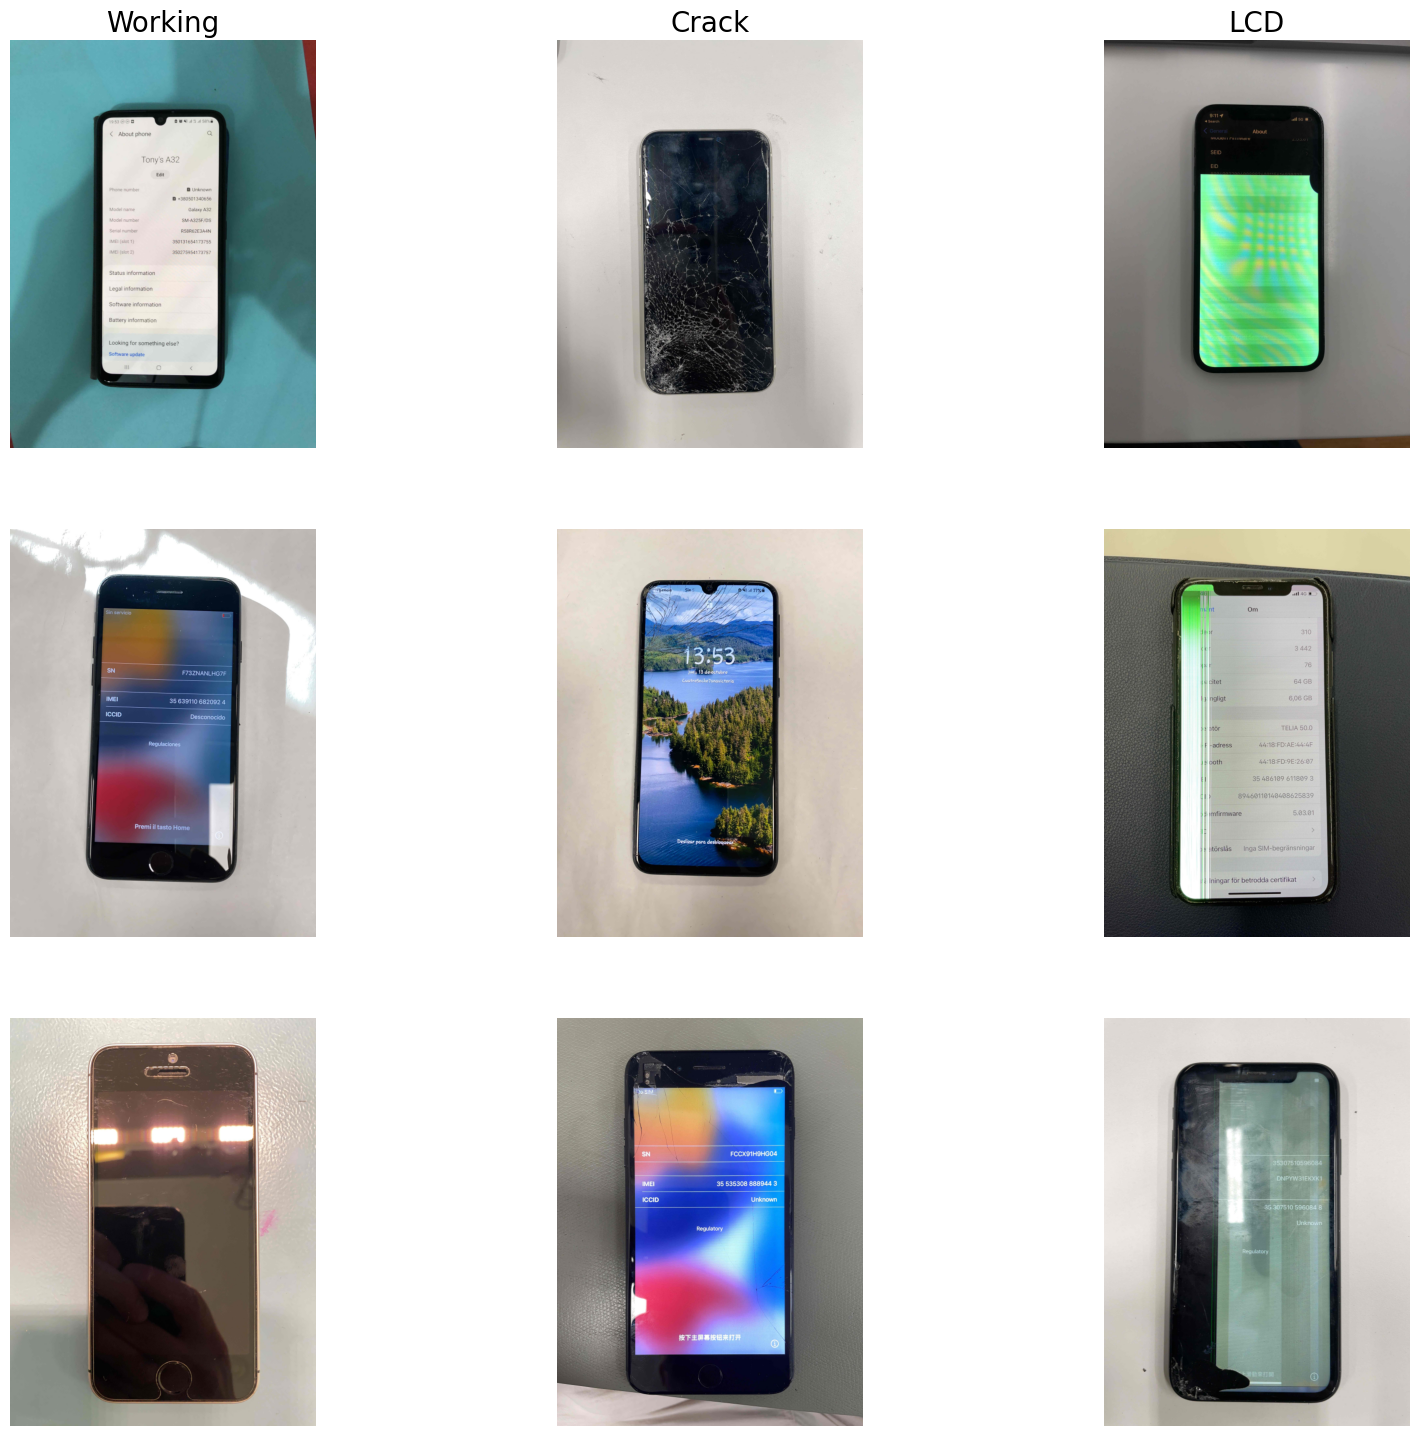

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 18.0) # set default size of plots
num_classes = len(CLASS_NAMES)

samples_per_class = 3
for num_cls, cls in enumerate(CLASS_NAMES):
    idxs = np.flatnonzero(y_train == num_cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + num_cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx], plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls, fontsize=20)
plt.show()

In [8]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

In [9]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])  
            pass
            y_pred[i]= int(np.argmax(np.bincount(closest_y)))
            pass
        return y_pred.astype(int)

In [10]:
X_train_reshape = np.reshape(X_train_norm, (X_train_norm.shape[0], -1))
X_test_reshape = np.reshape(X_test_norm, (X_test_norm.shape[0], -1))
print(X_train_reshape.shape, X_test_reshape.shape)

(181, 1460472) (78, 1460472)


In [11]:
classifier = KNearestNeighbor()
classifier.train(X_train_reshape, y_train)
dists= classifier.compute_distances(X_test_reshape)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
num_test=X_test.shape[0]
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 37 / 78 correct => accuracy: 0.474359


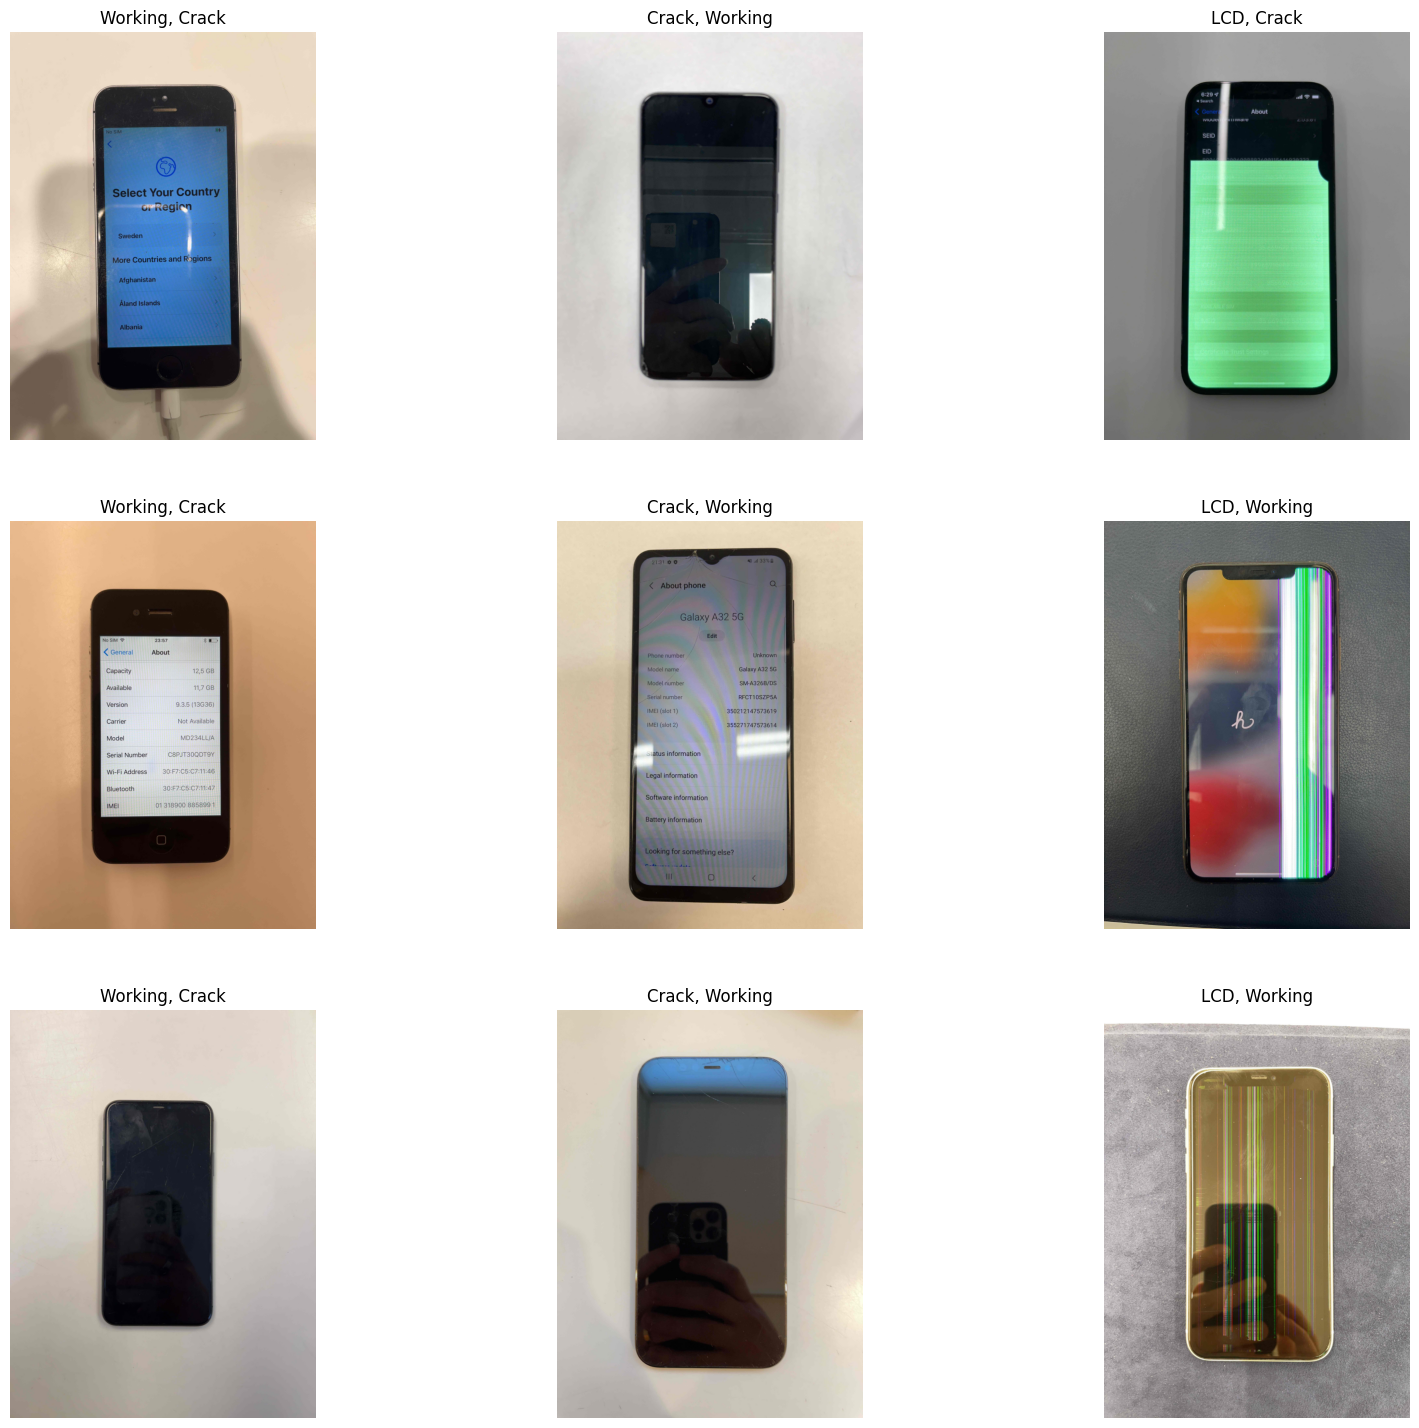

In [12]:
plt.rcParams['figure.figsize'] = (20.0, 18.0) # set default size of plots
num_classes = len(CLASS_NAMES)
samples_per_class = 3
for num_cls, cls in enumerate(CLASS_NAMES):
    idxs = np.flatnonzero(y_test == num_cls)   

    misclas_idxs = np.flatnonzero(np.array(y_test_pred )[idxs] != num_cls)

    if samples_per_class < len(misclas_idxs):
        misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + num_cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]], plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(CLASS_NAMES[num_cls]) + ", " + str(CLASS_NAMES[np.array(y_test_pred)[idxs[idx]]]))
plt.show()

In [13]:
print(y_test_pred)
print(y_test)

[0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0
 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0]
[1 1 0 1 1 1 1 0 0 0 0 1 1 2 0 0 1 1 0 0 0 1 1 1 1 1 0 2 1 2 0 1 1 1 1 0 0
 2 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 2 1 0 1 0 0 1 1 0 1 0 0 0 0 0 2 0 0
 0 0 1 2]


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
num_neigs=[1,2,3,4,5]
kFold = StratifiedKFold(n_splits = 3, shuffle = True)

confusion_matrices = []
acc = []

for k in num_neigs:
    for train_index, test_index in kFold.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
        std = X_train.std(axis=(0,1,2)) # same for std
        X_train_norm = (X_train - mu)/std
        X_test_norm = (X_test - mu)/std
        
        X_train_reshape = np.reshape(X_train_norm, (X_train_norm.shape[0], -1))
        X_test_reshape = np.reshape(X_test_norm, (X_test_norm.shape[0], -1))
        
        
        KNN=KNearestNeighbor()
        KNN.train(X_train_reshape, y_train)
        dists= KNN.compute_distances(X_test_reshape)
        y_test_pred = KNN.predict_labels(dists, k=k)
        num_correct = np.sum(y_test_pred == y_test)
        num_test=X_test.shape[0]
        accuracy = float(num_correct) / num_test
        
        acc.append(accuracy)


    confusion_matrices.append(
        confusion_matrix(y_test, y_test_pred, labels = CLASS_NUMBERS)
    )
    print(f'Mean accuracy for KNN with {k} neighbour(s): {np.mean(acc)}')
    print(classification_report(y_test, y_test_pred, labels = CLASS_NUMBERS, target_names=CLASS_NAMES))
        

Mean accuracy for KNN with 1 neighbour(s): 0.5791677804508599
              precision    recall  f1-score   support

     Working       0.60      0.66      0.63        44
       Crack       0.56      0.51      0.54        37
         LCD       0.25      0.20      0.22         5

    accuracy                           0.57        86
   macro avg       0.47      0.46      0.46        86
weighted avg       0.56      0.57      0.57        86

Mean accuracy for KNN with 2 neighbour(s): 0.5752249844070213
              precision    recall  f1-score   support

     Working       0.53      0.70      0.61        44
       Crack       0.46      0.35      0.40        37
         LCD       0.00      0.00      0.00         5

    accuracy                           0.51        86
   macro avg       0.33      0.35      0.34        86
weighted avg       0.47      0.51      0.48        86

Mean accuracy for KNN with 3 neighbour(s): 0.5765095488431495
              precision    recall  f1-score   suppor

Confusion matrix of KNN, k = 1


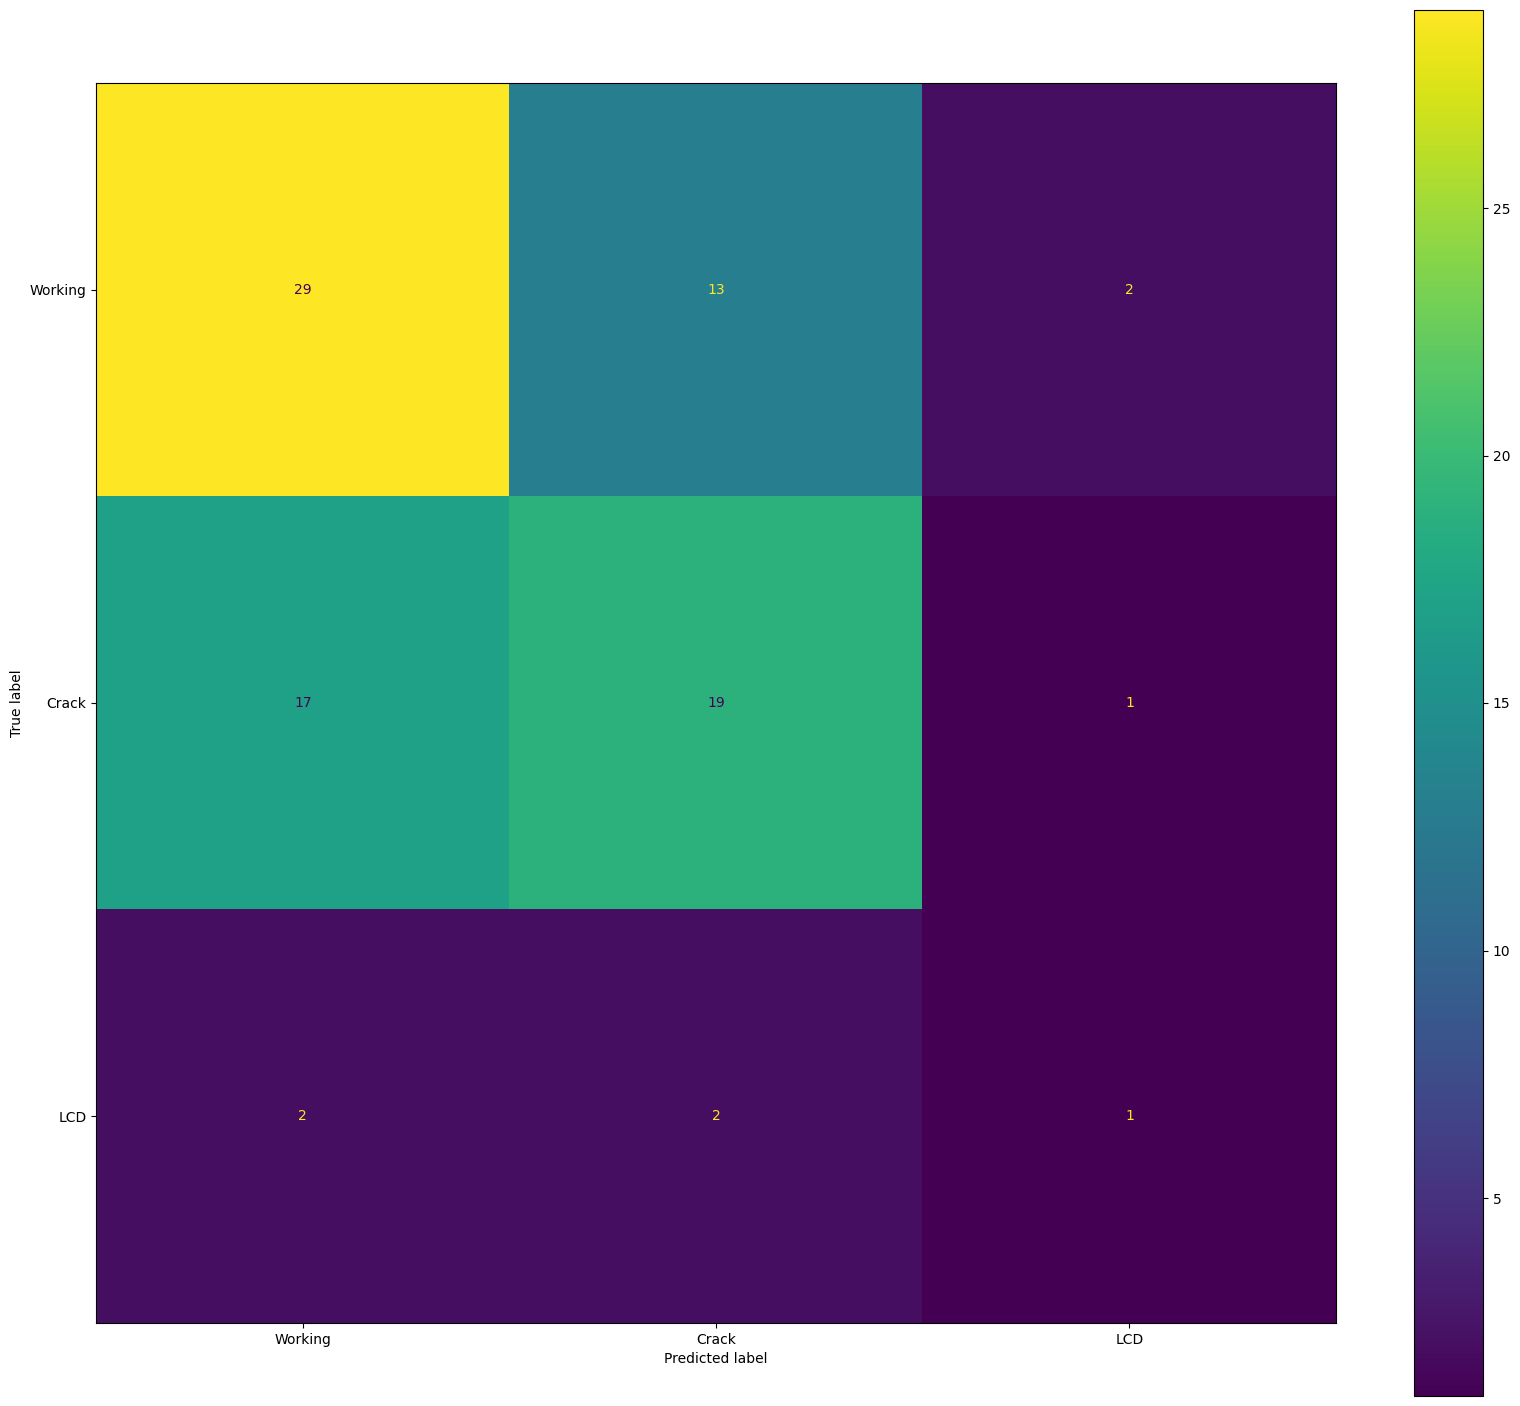

Confusion matrix of KNN, k = 2


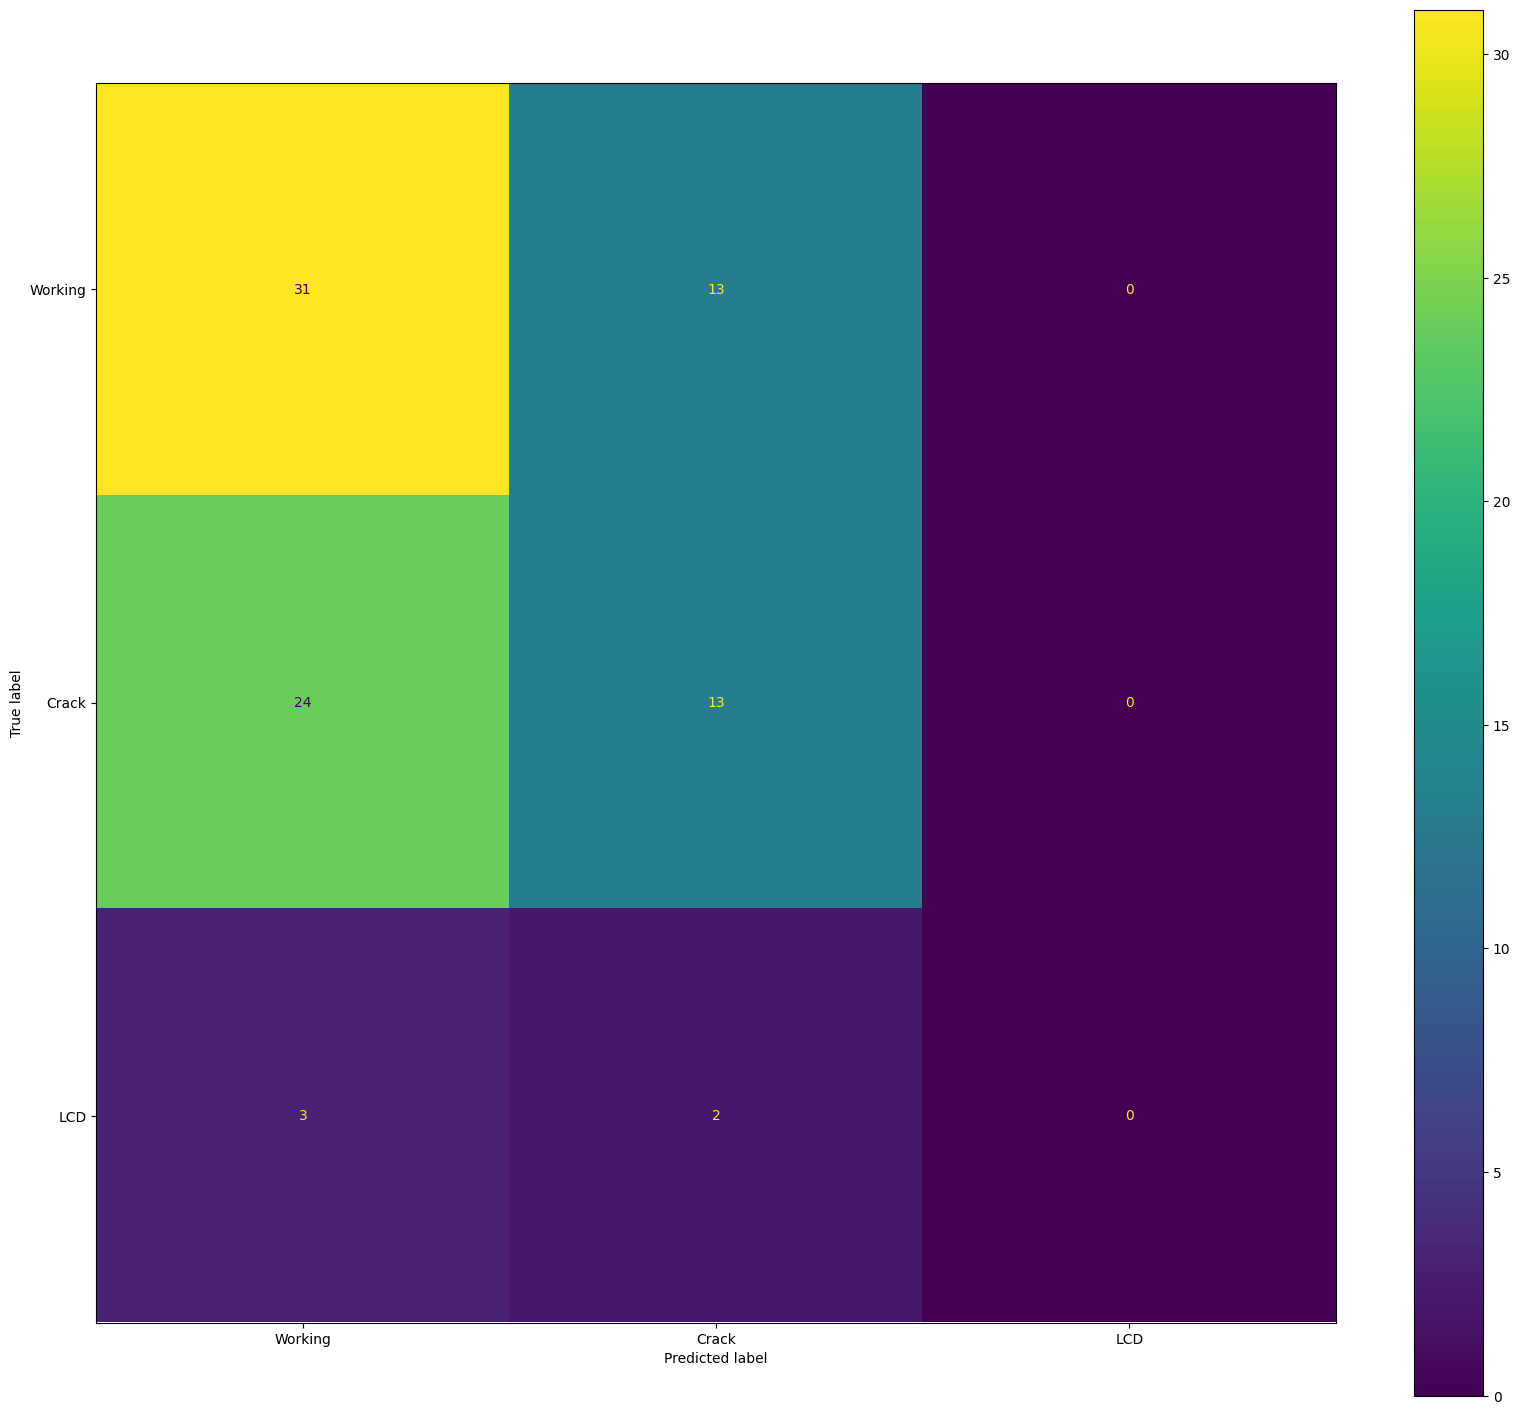

Confusion matrix of KNN, k = 3


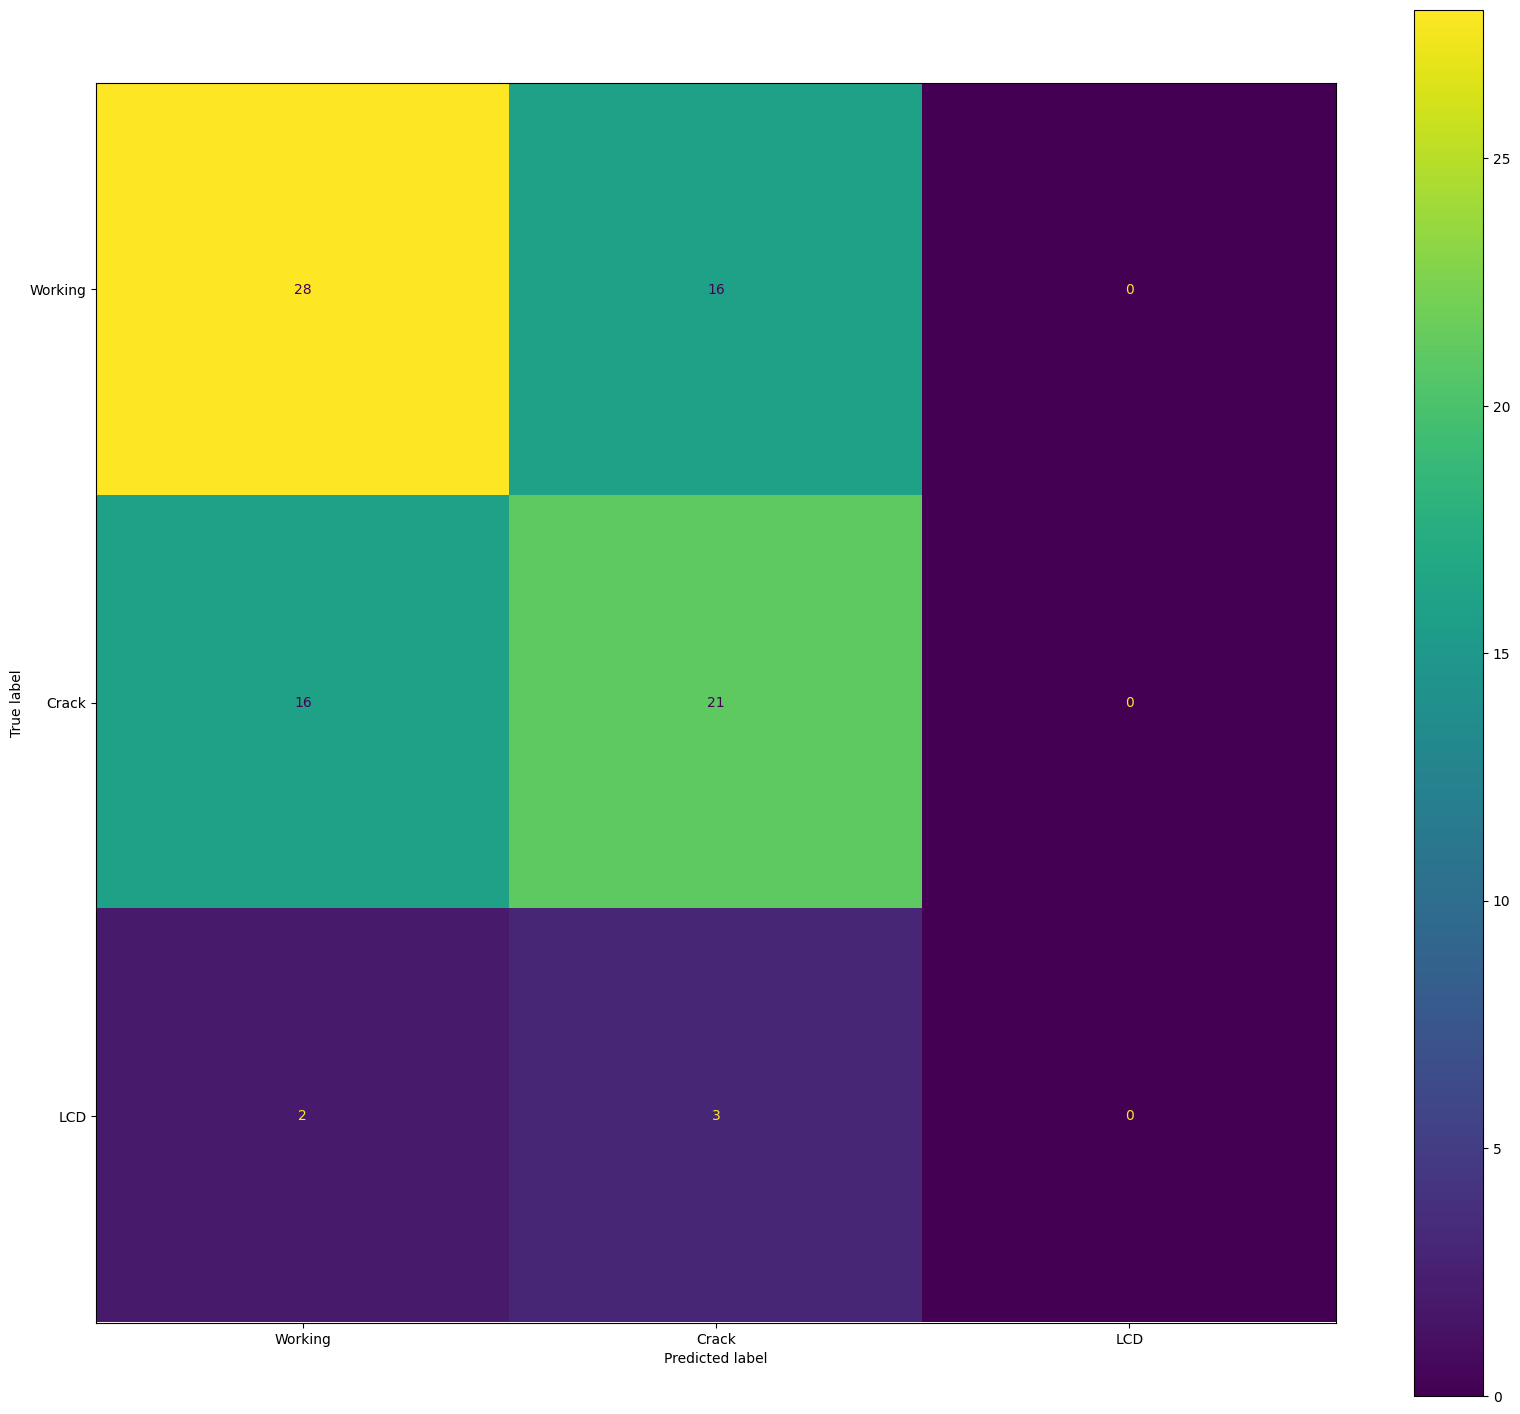

Confusion matrix of KNN, k = 4


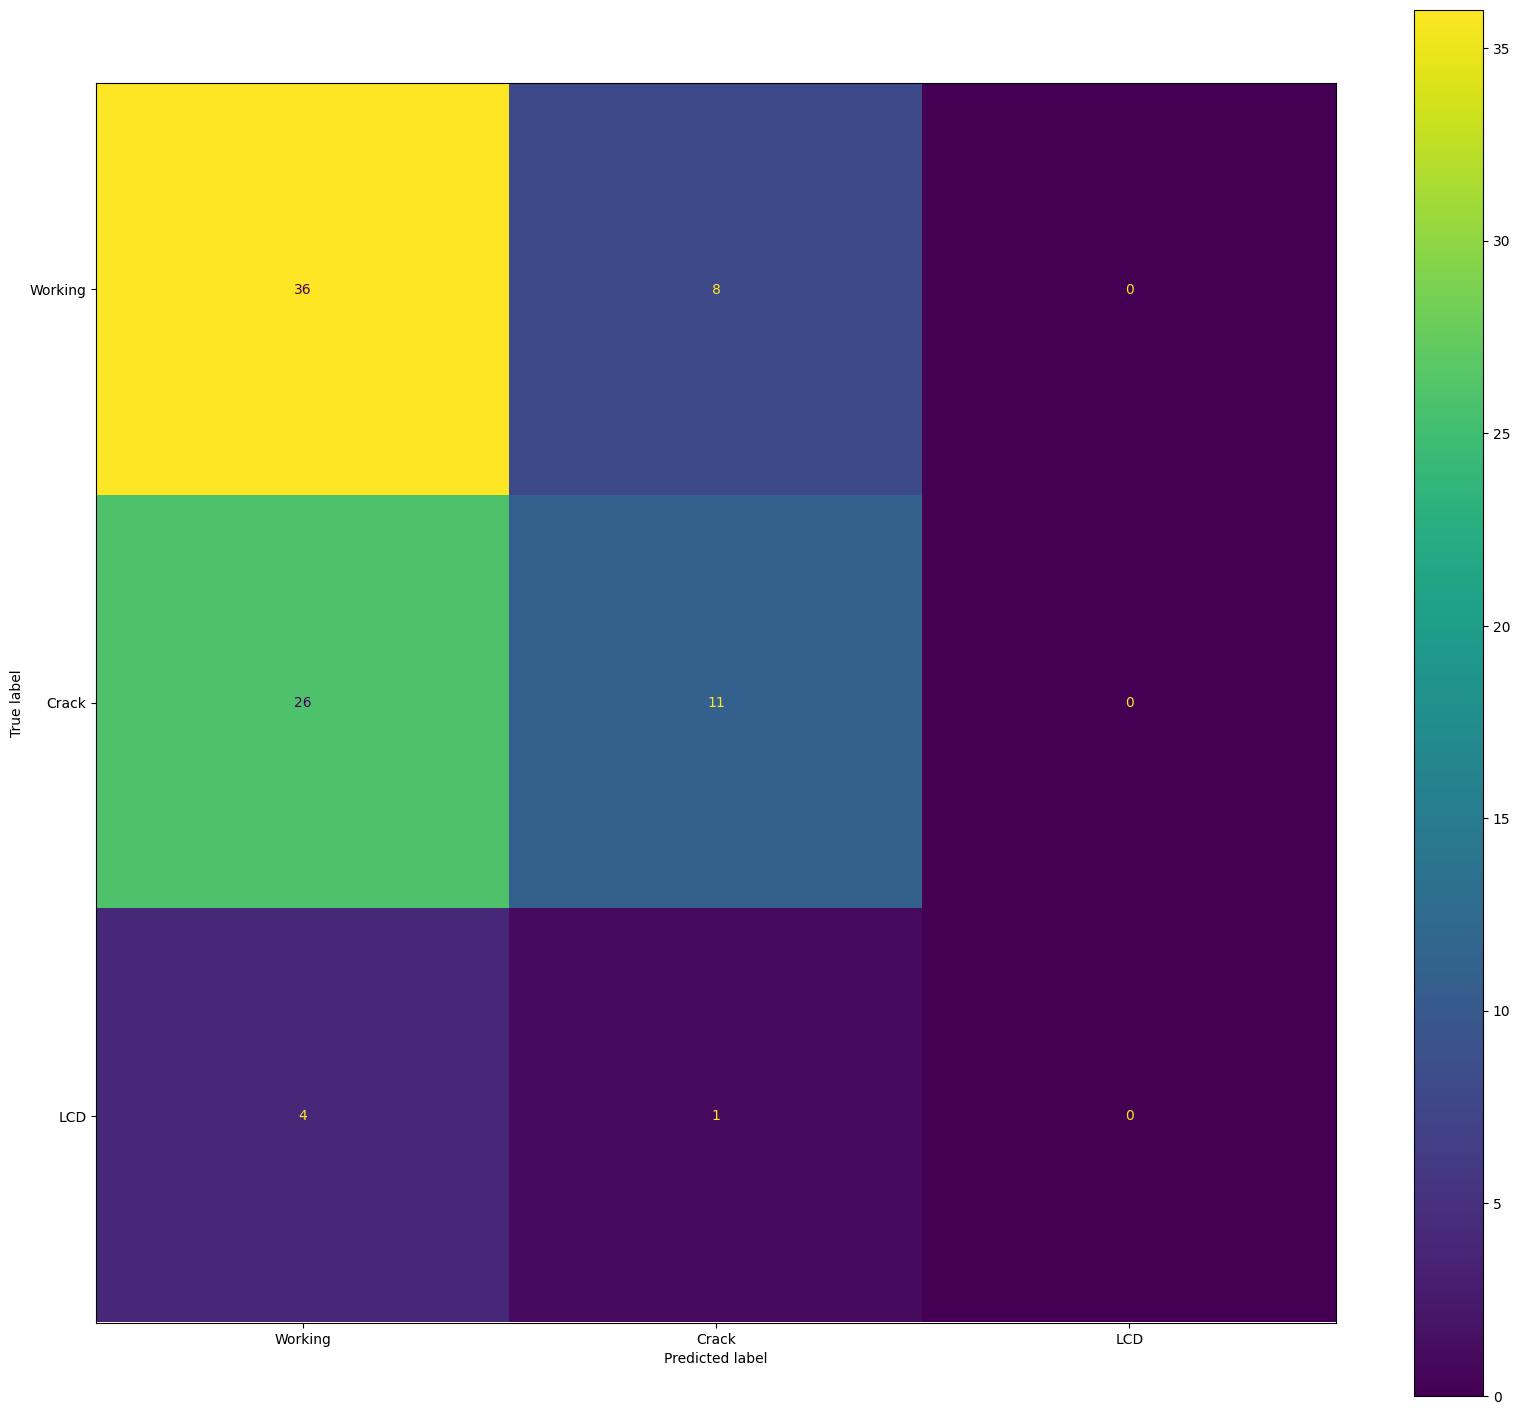

Confusion matrix of KNN, k = 5


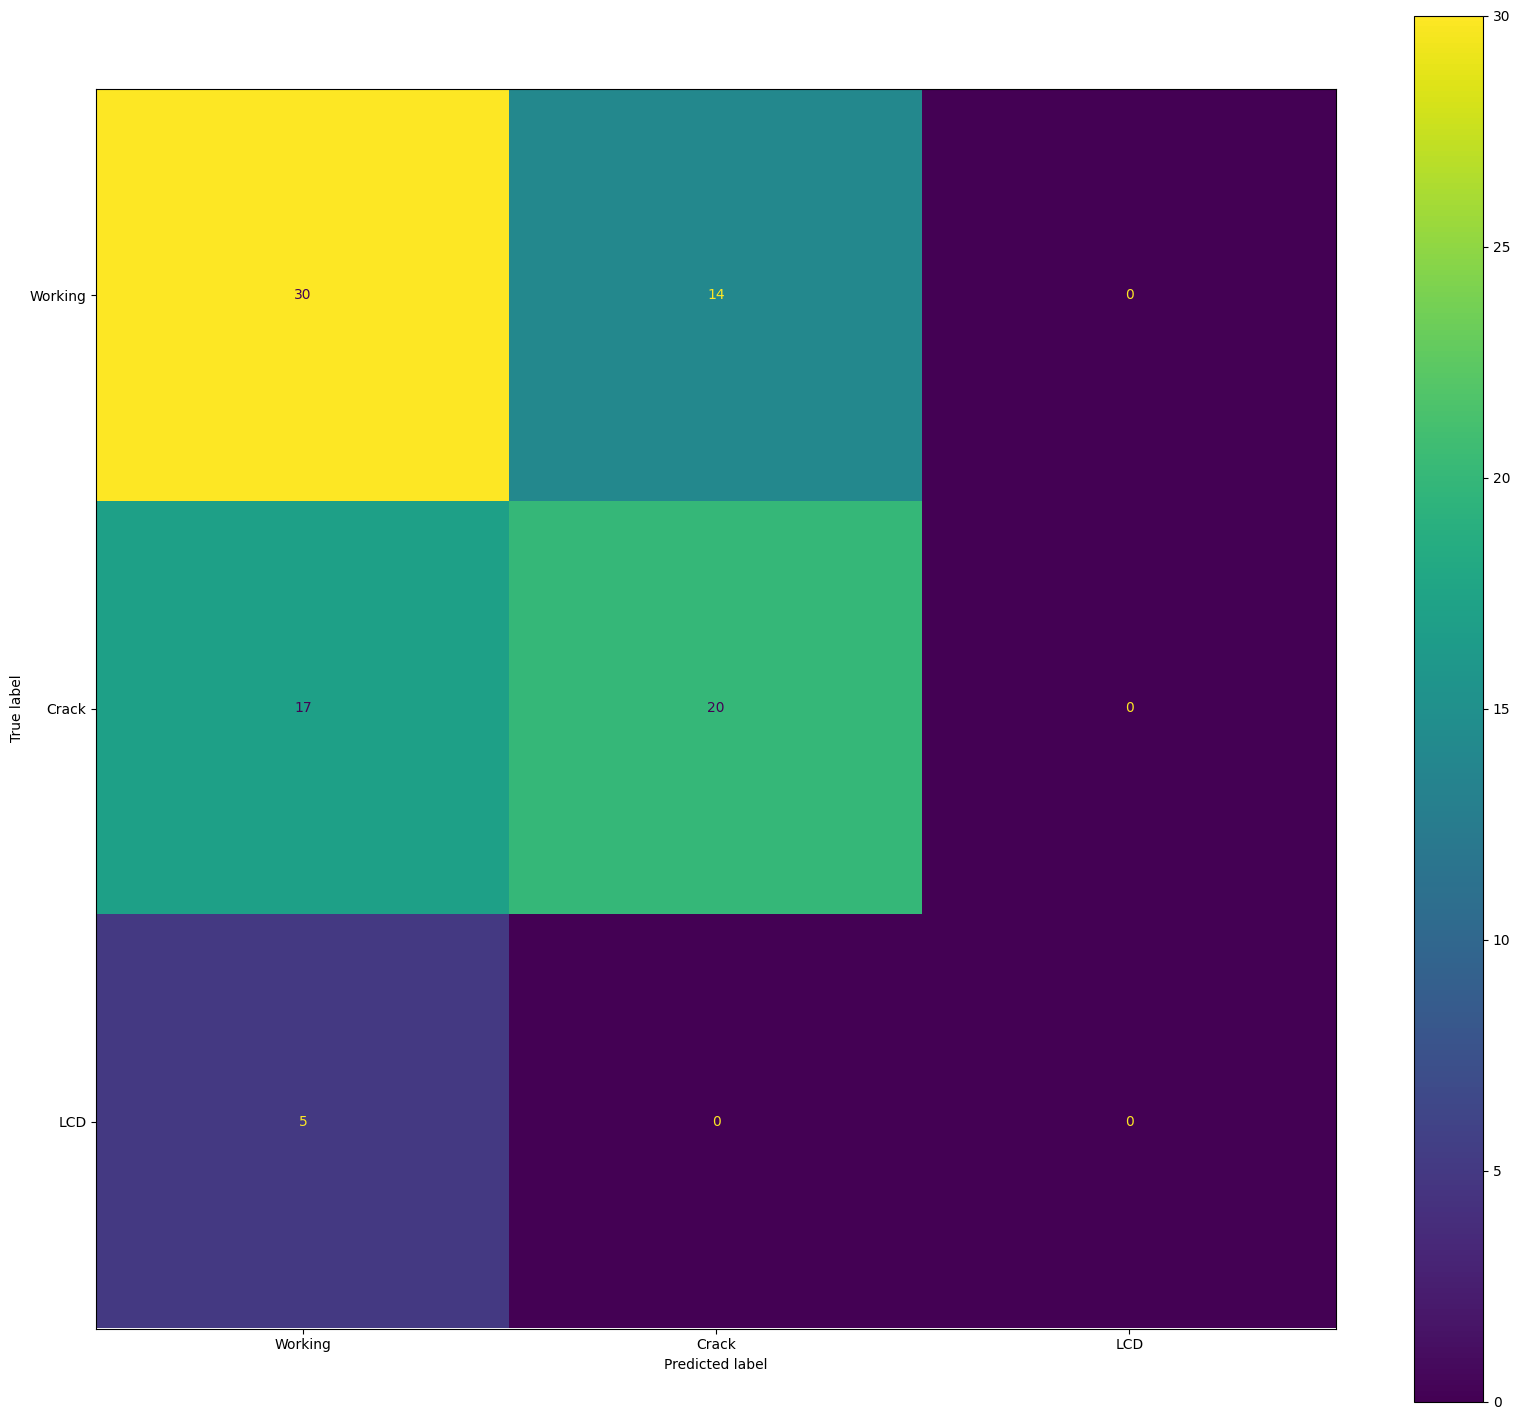

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for i in num_neigs:
    print(f"Confusion matrix of KNN, k = {i}" )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrices[i-1], 
        display_labels = CLASS_NAMES
    )
    disp.plot()
    plt.show()

In [16]:
# discuss
from keras.preprocessing.image import ImageDataGenerator
dxs= np.flatnonzero(y == 2)
lcd_only=X[idxs]
y_lcd=y[idxs]
generator = datagen.flow(lcd_only, y_lcd, sample_weight=sample_weight,batch_size=30)

2022-12-04 19:43:22.761835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 19:43:36.709348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/cv2/../../lib64:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/perl-5.34.1-4ryb2w6tlh6ha54x25kkpq7l5zjq56do/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/pcre2-10.36-viek2bpe7b5ktcr3qpyl2qhipy2ybjxs/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/g

NameError: name 'datagen' is not defined